## Librerias

In [1]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




## Data

In [2]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [3]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Grupo_Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41-63,64667906,2,1834,2558114,10,1279057
2,1993,ROJO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,76728037,2,1203,4883644,7,2441822
3,1997,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41-63,121930553,2,3077,4238816,16,2119408
4,1998,AZUL,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,130833256,2,2791,8213167,16,4106584
5,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19-41,101517338,2,2410,8014069,13,4007035
6,1998,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19-41,180459141,4,4223,6450375,23,1612594


In [4]:
summary(data$suma_pagos)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  148662  1914583  4185008  7373264  9182684 68223671 

## Seleccion de variables

In [5]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Grupo_Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2012 
Variable: Color - Categoría de referencia: PLATA 
Variable: Carroceria - Categoría de referencia: HATCHBACK 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Grupo_Edad - Categoría de referencia: 41-63 


'data.frame':	258 obs. of  14 variables:
 $ Modelo          : Factor w/ 18 levels "2012","1993",..: 2 2 3 4 4 4 4 4 4 5 ...
 $ Color           : Factor w/ 19 levels "PLATA","AMARILLO",..: 16 16 5 3 5 5 9 16 18 5 ...
 $ Carroceria      : Factor w/ 10 levels "HATCHBACK","BUS-BUSETA",..: 8 8 8 8 8 8 10 8 8 8 ...
 $ CLASE_FASECOLDA : Factor w/ 7 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 1 1 5 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 3 levels "Particular","Publico",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Sexo_Aseg       : Factor w/ 2 levels "M","F": 2 1 1 2 2 1 2 2 1 2 ...
 $ Grupo_Edad      : Factor w/ 3 levels "41-63","19-41",..: 1 2 1 2 2 2 1 1 2 1 ...
 $ valor           : num  6.47e+07 7.67e+07 1.22e+08 1.31e+08 1.02e+08 ...
 $ n_siniestros    : int  2 2 2 2 2 4 2 2 2 2 ...
 $ exposicion_total: int  1834 1203 3077 2791 2410 4223 1099 1832 2197 2395 ...
 $ suma_pagos      : num  2558114 4883644 4238816 821

## FRECUENCIA 

In [6]:
# Modelo inicial con todas las variables (Poisson)
modelo_inicial <- glm(
  n_siniestros ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
                 TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + 
                 offset(log(exposicion_total)),
  family = poisson,
  data = data
)

# Selección stepwise
modelo_stepwise <- step(modelo_inicial, direction = "forward", trace = FALSE)

# Mostrar la fórmula seleccionada
cat("Fórmula seleccionada por stepwise:\n")
print(formula(modelo_stepwise))

# Extraer los términos de la fórmula seleccionada
formula_seleccionada <- formula(modelo_stepwise)
cat("\nCreando modelo final con quasi-Poisson...\n")

# Crear modelo final con Quasi-Poisson especificando la fórmula explícitamente
modelo_frecuencia_final <- update(modelo_stepwise, family = quasipoisson)

# Resumen del modelo final
summary(modelo_frecuencia_final)

Fórmula seleccionada por stepwise:
n_siniestros ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Grupo_Edad + offset(log(exposicion_total))

Creando modelo final con quasi-Poisson...



Call:
glm(formula = n_siniestros ~ log(valor) + Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Grupo_Edad + offset(log(exposicion_total)), family = quasipoisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5697  -0.2819   0.0000   0.2932   2.0591  

Coefficients: (3 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                             3.792444   0.905644   4.188 4.20e-05
log(valor)                             -0.527869   0.043207 -12.217  < 2e-16
Modelo1993                             -0.901766   0.318832  -2.828  0.00515
Modelo1997                             -1.189657   0.426955  -2.786  0.00584
Modelo1998                             -0.783195   0.190254  -4.117 5.59e-05
Modelo1999                             -0.800401   0.313894  -2.550  0.01151
Modelo2000                             -0.885224   0.225677 

## Evaluación

In [7]:
# Verificar sobredispersión
dispersion <- sum(residuals(modelo_frecuencia_final, type = "pearson")^2) / modelo_frecuencia_final$df.residual
cat("Parámetro de dispersión:", dispersion, "\n")

if (dispersion > 1.5) {
  cat("ADVERTENCIA: Hay evidencia de sobredispersión. Considerar modelo quasi-Poisson o binomial negativa.\n")
} else {
  cat("La dispersión parece apropiada para el modelo Poisson.\n")
}

Parámetro de dispersión: 0.3242812 
La dispersión parece apropiada para el modelo Poisson.


Warning message in title(...):
“conversion failure on '√|Residuos deviance|' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in title(...):
“conversion failure on '√|Residuos deviance|' in 'mbcsToSbcs': dot substituted for <88>”
Warning message in title(...):
“conversion failure on '√|Residuos deviance|' in 'mbcsToSbcs': dot substituted for <9a>”


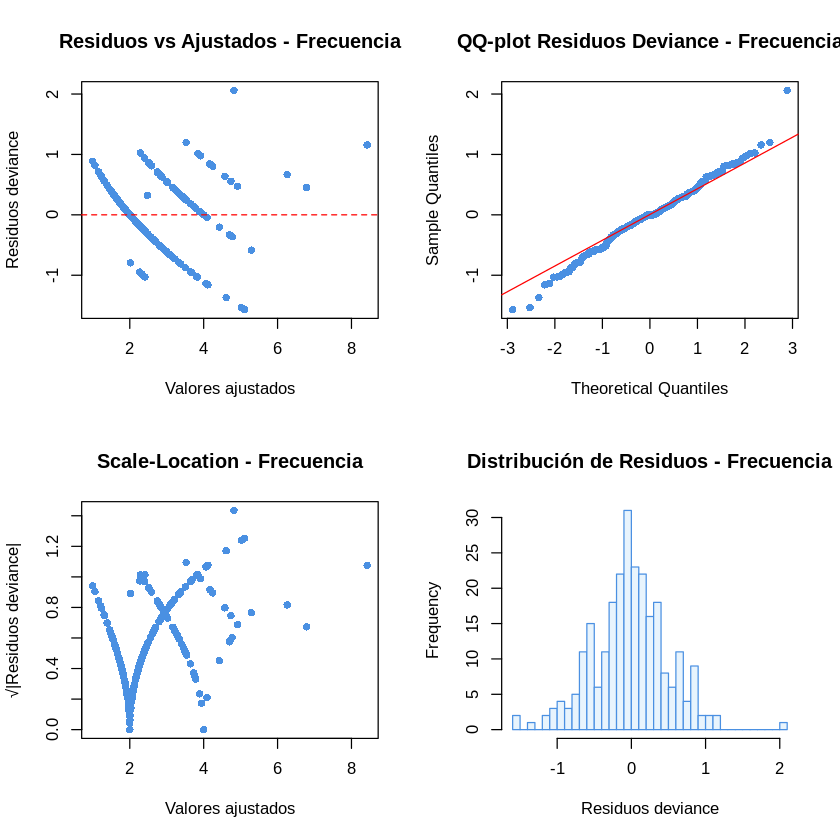

In [8]:
# Gráficos diagnósticos para el modelo de frecuencia
residuos_deviance <- residuals(modelo_frecuencia_final, type = "deviance")
residuos_pearson <- residuals(modelo_frecuencia_final, type = "pearson")
valores_ajustados <- fitted(modelo_frecuencia_final)

# Panel de diagnósticos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Frecuencia",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance - Frecuencia",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Frecuencia",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos - Frecuencia",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

Quasi-Poisson model 


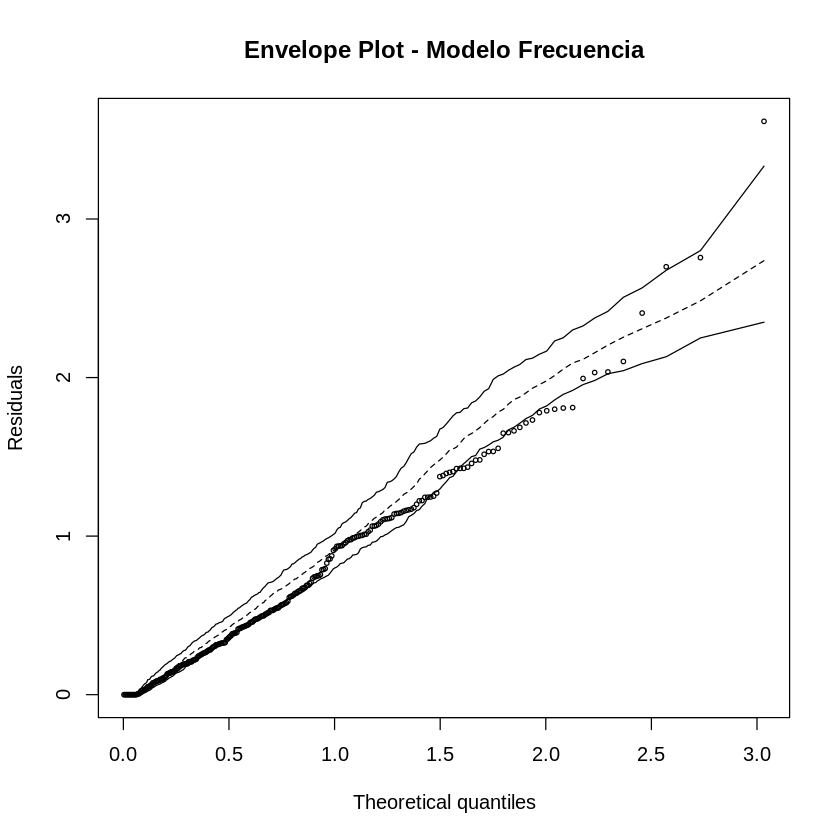

In [9]:
# Envelope plot para el modelo de frecuencia
envelope_frecuencia <- hnp(modelo_frecuencia_final,
                          halfnormal = TRUE,
                          plot = TRUE,
                          main = "Envelope Plot - Modelo Frecuencia",
                          col = "#4A90E2")

## Diagnóstico del ajuste del modelo

In [10]:
# Análisis detallado del problema
cat("=== DIAGNÓSTICO DEL MODELO ===\n")
cat("Dispersión:", dispersion, "\n")
cat("Deviance/df:", deviance(modelo_frecuencia_final)/modelo_frecuencia_final$df.residual, "\n")

# Verificar distribución de la variable respuesta
cat("\n=== DISTRIBUCIÓN DE n_siniestros ===\n")
table(data$n_siniestros)

# Verificar ceros excesivos
prop_ceros <- sum(data$n_siniestros == 0) / nrow(data)
cat("\nProp. de ceros:", round(prop_ceros, 3), "\n")

# Verificar valores ajustados vs observados
mu_hat <- fitted(modelo_frecuencia_final)
cat("Rango valores ajustados:", round(range(mu_hat), 3), "\n")
cat("Media n_siniestros:", round(mean(data$n_siniestros), 3), "\n")

=== DIAGNÓSTICO DEL MODELO ===
Dispersión: 0.3242812 
Deviance/df: 0.324681 

=== DISTRIBUCIÓN DE n_siniestros ===



  1   2   3   4   6   8  10  12 
  4 188   1  52   9   2   1   1 


Prop. de ceros: 0 
Rango valores ajustados: 0.995 8.426 
Media n_siniestros: 2.647 


## Exportar Modelos

In [11]:
# Guardar modelo de frecuencia simple
saveRDS(modelo_frecuencia_final, file = "../models/modelo_frecuencia_quasipoisson.rds")

# Guardar modelo con información adicional
modelo_frecuencia_info <- list(
  modelo = modelo_frecuencia_final,
  aic = AIC(modelo_frecuencia_final),
  formula = formula(modelo_frecuencia_final),
  family = "Quasi-Poisson",
  dispersion = summary(modelo_frecuencia_final)$dispersion,
  fecha_entrenamiento = Sys.Date()
)

saveRDS(modelo_frecuencia_info, file = "../models/modelo_frecuencia_quasipoisson_completo.rds")

cat("Modelos exportados exitosamente:\n")
cat("- modelo_frecuencia_quasipoisson.rds\n")
cat("- modelo_frecuencia_quasipoisson_completo.rds\n")

Modelos exportados exitosamente:
- modelo_frecuencia_quasipoisson.rds
- modelo_frecuencia_quasipoisson_completo.rds
